In [1]:
!nvidia-smi

Mon Dec 14 18:49:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Installing tensorflow 
import tensorflow as tf
print(tf.version.VERSION) #Checking the tensorflow version

2.3.0


In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
# tensorflow garden contains state of the art implementations of the models

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 215kB 12.0MB/s 
     |████████████████████████████████| 14.5MB 250kB/s 
     |████████████████████████████████| 471kB 58.2MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 25.9MB 99kB/s 
     |████████████████████████████████| 174kB 60.8MB/s 
     |████████████████████████████████| 3.6MB 53.6MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
     |████████████████████████████████| 358kB 59.0MB/s 
     |████████████████████████████████| 1.1MB 49.8MB/s 
     |████████████████████████████████| 11.6MB 211kB/s 
     |████████████████████████████████| 36.7MB 89kB/s 
     |████████████████████████████████| 276kB 62.6MB/s 
     |████████████████████████████████| 2.2MB 47.0MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 


In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [5]:
# Checking the versions 
print("TF Version: ", tf.__version__)
print("Hub Version: ", hub.__version__)
print('GPU is', "available" if tf.config.experimental.list_physical_devices("GPU") else "Not Available") 

TF Version:  2.3.0
Hub Version:  0.10.0
GPU is available


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
#importing the quora dataset

train_df = pd.read_csv("/content/drive/My Drive/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/test.csv")

In [8]:
train_df.shape

(1306122, 3)

In [9]:
train_df.tail(20) # Returns Last 20 rows

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


In [10]:
# Creating train and validation set
from sklearn.model_selection import train_test_split

In [13]:
# Since BERT takes a lot of time to train the data. a sample of 10000 dataset was created 
# because of the memory exhaustion tf.data api is used to prevent the GPU from data starvation. these creates a data pipeline where large data can be optimized and sent to the GPU
# Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues.
quora_train, remaining_data = train_test_split(train_df, random_state = 42, train_size= 0.0085, stratify= train_df.target.values)
quora_validation, _ = train_test_split(remaining_data, random_state = 42, train_size =0.00085, stratify = remaining_data.target.values)
quora_train.shape, quora_validation.shape

((11102, 3), (1100, 3))

In [14]:
# the size of the bert model is very large because it is trained on very large datasets and consists of 100 million+ parameters 
# Time taken to train a BERT Model is very expensive. and most of the time the memory gets exhausted.
# Therefore only 10000 data was selected for training data and 1000 for validation set
# stratified was used to allow proper allocation of the target values.

In [15]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((quora_train['question_text'].values, quora_train['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((quora_validation.question_text.values, quora_validation.target.values))

  for text, label in train_data.take(1): #iterating over the train data to get the first value from the train_data
    print(text)
    print(label)

tf.Tensor(b'Me, my son, my daughter, and husband will wait till there 18 to have group sex. Wired or what?', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [16]:
%%time
# Data pre-processing will consists of transforming text to BERT input features
# input_word_ids, input_mask, segment_ids
# tokenization will be done with the help of BERT Tokenizer

#label categories
label_list = [0,1]

# maximum length of (token) input sequences.
max_seq_length = 128

train_batch_size = 32

# Downloading a Pre-trained BERT Model from the tensor flow hub
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
# trainable = true means all the parameters will be fine-tuned

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_cased = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_cased) # this step handles all the pre-processing



CPU times: user 19.2 s, sys: 4.78 s, total: 23.9 s
Wall time: 1min 14s


In [17]:
bert_tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?") # this is the way bert performs tokenization

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [18]:
bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?")) # this is the way bert performs tokenization

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [19]:
# we are going to prepend "CLS" at the start and "SEP" at the end
# padding will be done to make the sentence of equal length

In [20]:
# we will need to transform our data into a format which the BERT Model understand.
# we will create inputexamples using classifier_data_lib's constructor InputExample provided in the BERT Library.

In [21]:
# the function will convert rows to input features and label.

def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = bert_tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list, max_seq_length, bert_tokenizer)

  return(feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

In [22]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout =[tf.int32,tf.int32,tf.int32,tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

In [23]:
# Creating a tensorflow input pipeline with tf.data

In [24]:
with tf.device('/cpu:0'):
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(100)
  .batch(32,drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))


  # valid data
  valid_data = (valid_data.map(to_feature_map,
                                         num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32,drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))  

In [25]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [26]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [27]:
# Adding Classification Head to the BERT Layer
# BERT will generate 768 dimension contextualised word

In [28]:
def create_bert_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
  
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  #dropout is added to prevent overfitting on the training set
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop) #because we are doing binary classification sigmoid will give value between 0 AND 1
  quora_model = tf.keras.Model(
      inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
      },
      outputs = output)
  return quora_model

In [29]:
# Fine tuning BERT
model = create_bert_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

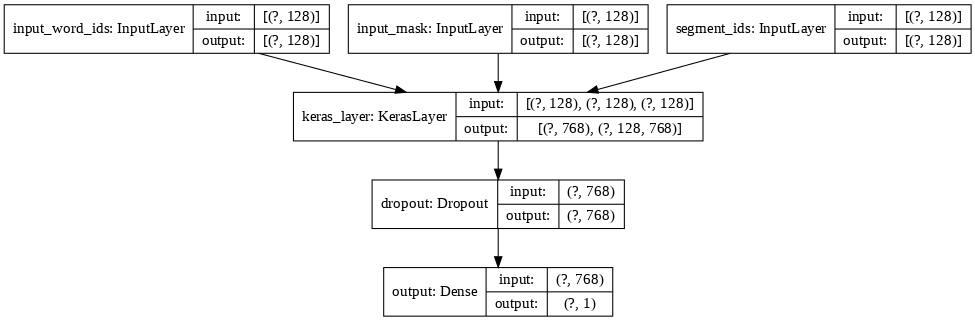

In [30]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi = 76)

In [31]:
# train_model
epochs = 5
history_quora = model.fit(train_data,
                          validation_data = valid_data,
                          epochs = epochs,
                          verbose = 1)


Epoch 1/5
346/346 [==============================] - ETA: 0s - loss: 0.1664 - binary_accuracy: 0.9394WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_test_batch_end` time: 0.2804s). Check your callbacks.


346/346 [==============================] - 307s 886ms/step - loss: 0.1664 - binary_accuracy: 0.9394 - val_loss: 0.1466 - val_binary_accuracy: 0.9531
Epoch 2/5
346/346 [==============================] - 305s 882ms/step - loss: 0.1004 - binary_accuracy: 0.9614 - val_loss: 0.1380 - val_binary_accuracy: 0.9559
Epoch 3/5
346/346 [==============================] - 306s 884ms/step - loss: 0.0529 - binary_accuracy: 0.9813 - val_loss: 0.1988 - val_binary_accuracy: 0.9522
Epoch 4/5
346/346 [==============================] - 306s 884ms/step - loss: 0.0262 - binary_accuracy: 0.9908 - val_loss: 0.1890 - val_binary_accuracy: 0.9540
Epoch 5/5
346/346 [==============================] - 305s 882ms/step - loss: 0.0121 - binary_accuracy: 0.9961 - val_loss: 0.2291 - val_binary_accuracy: 0.9522


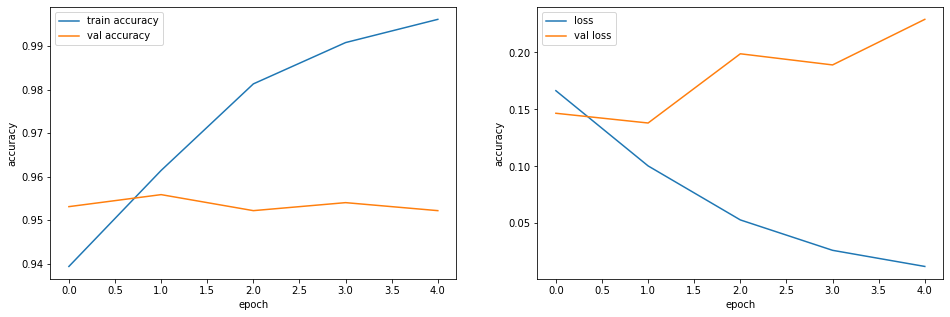

In [32]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history_quora.history['binary_accuracy'], label='train accuracy')
plt.plot(history_quora.history['val_binary_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

plt.subplot(1,2,2)
plt.plot(history_quora.history['loss'], label='loss')
plt.plot(history_quora.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

plt.show()

In [100]:
sample_quora_questions = ['Dont mess with me otherwise, I will kill you?','What is the currency in Langkawi?','What plant can I grow indoors?']
test_data = tf.data.Dataset.from_tensor_slices((sample_quora_questions,[0]*len(sample_quora_questions)))
test_data = (test_data.map(to_feature_map).batch(1))
prediction = model.predict(test_data)
threshold = 0.5 #between 0 and 1
['Quesition is Insincere' if pred>= threshold else 'Question is Sincere' for pred in prediction]

['Quesition is Insincere', 'Question is Sincere', 'Question is Sincere']

In [102]:
### Predicting F1-Score
from sklearn.metrics import confusion_matrix
validation_question = quora_validation['question_text'].tolist()
validation_target = quora_validation['target']
testing = tf.data.Dataset.from_tensor_slices((validation_question,[0]*len(validation_question)))
test_data = (testing.map(to_feature_map).batch(1))
p1 = model.predict(test_data)
prediction = (p1 > 0.5)

print("Accuracy of the model : ", accuracy_score(prediction, validation_target))
print('F1-score: ', f1_score(prediction,validation_target))
print('Confusion matrix:')
confusion_matrix(validation_target,prediction)

Accuracy of the model :  0.9518181818181818
F1-score:  0.6490066225165563
Confusion matrix:


array([[998,  34],
       [ 19,  49]])

In [86]:
sample_quora_questions = test_df['question_text'].tolist()

In [79]:
# Now we apply the above same function on the test dataset consisting of sample 200 test questions

In [87]:
sample_quora_questions = sample_quora_questions[:200]
test_data = tf.data.Dataset.from_tensor_slices((sample_quora_questions,[0]*len(sample_quora_questions)))
test_data = (test_data.map(to_feature_map).batch(1))
prediction = model.predict(test_data)
threshold = 0.5 #between 0 and 1
answers = ['Insincere' if pred>= threshold else 'Sincere' for pred in prediction]

In [88]:
sample_dict = {'Questions':sample_quora_questions, 'Target':answers}

In [89]:
sample_df = pd.DataFrame(sample_dict)

In [93]:
sample_df.to_csv("Sample BERT Submission",index=False)